# Operability Analysis of an Air Cooling System using DWSIM and Opyrability

Adapted from original example by: Prof. Nicolas Spogis, PhD

This example simulates an air conditioning system based on a vapor compression cycle using the DWSIM simulator. The objective is to integrate this simulation with Opyrability for performance and optimal operation analysis.

The system represents a typical refrigeration cycle with a compressor, condenser, expansion valve, and evaporator. The refrigerant is compressed, condensed, expanded, and evaporated to cool an environment.



*Figure 1: DWSIM flowsheet for the air cooling system.*

The analysis maps the relationship between the following inputs and outputs:

| Input (AIS)                      | Output (AOS)                 |
|----------------------------------|------------------------------|
| Evaporator Temperature [°C]      | Coefficient of Performance (COP) |
| Condenser Temperature [°C]       | CAPEX (Capital Expenditure)  |

**Output Variable Definitions:**
- **COP (Coefficient of Performance):** A measure of the efficiency of a refrigeration cycle. It expresses how much useful heat is removed (cooling) in relation to the electrical energy consumed by the compressor to perform this process. The general formula for a refrigeration cycle is `COP = Q_evap / W_comp`, where:
    - `Q_evap` is the heat absorbed by the evaporator (i.e., the useful thermal load, in kW).
    - `W_comp` is the work consumed by the compressor (electrical energy supplied, in kW).
In the DWSIM example, these values correspond to the energies measured in the energy streams: `Q_evap = E3` and `W_comp = E1`. Thus, **COP = E3 / E1**.
- **CAPEX (Capital Expenditure):** An estimate of the manufacturing cost of the heat exchangers (evaporator and condenser). This value is influenced by the required heat transfer area, which in turn depends on the LMTD (Log Mean Temperature Difference). The larger the LMTD, the smaller the area required to achieve the same heat transfer rate—resulting in a lower manufacturing cost. Therefore, CAPEX serves as an indirect indicator of the system's economic viability under different operating conditions.

This example is useful for demonstrating how performance and cost analyses can be conducted based on the system's operational variables, using optimization and operational flexibility assessment tools like Opyrability.

**Requirements:** This notebook requires a working installation of DWSIM, along with the necessary Python libraries (`opyrability`, `numpy`, `matplotlib`, `pythonnet`).

Let's start by importing the necessary libraries:

In [1]:
# remove the following two lines to run on linux
import pythoncom
pythoncom.CoInitialize()

from opyrability import multimodel_rep, OI_eval, AIS2AOS_map
import numpy as np
import matplotlib.pyplot as plt

# Call DWSIM DLLs
import clr

ModuleNotFoundError: No module named 'pythoncom'

The first step is to load the DWSIM libraries and establish a connection to the simulation. You'll need to update the DWSIM installation path to match your system.

In [ ]:
# Set your DWSIM installation path
dwsimpath = "C:\\Users\\[YourUser]\\AppData\\Local\\DWSIM\\" # Update this path

clr.AddReference(dwsimpath + "\\CapeOpen.dll")
clr.AddReference(dwsimpath + "\\DWSIM.Automation.dll")
clr.AddReference(dwsimpath + "\\DWSIM.Interfaces.dll")
clr.AddReference(dwsimpath + "\\DWSIM.GlobalSettings.dll")
clr.AddReference(dwsimpath + "\\DWSIM.SharedClasses.dll")
clr.AddReference(dwsimpath + "\\DWSIM.Thermodynamics.dll")
clr.AddReference(dwsimpath + "\\DWSIM.UnitOperations.dll")
clr.AddReference(dwsimpath + "\\DWSIM.Inspector.dll")
clr.AddReference(dwsimpath + "\\System.Buffers.dll")
clr.AddReference(dwsimpath + "\\DWSIM.Thermodynamics.ThermoC.dll")

We can now create a function to initialize the automation manager and then uses it to load the `Air Cooling.dwxmz` simulation file.

In [5]:
def open_DWSIM(dwsimpath, FlowsheetFile):
    from DWSIM.Automation import Automation3
    manager = Automation3()
    myflowsheet = manager.LoadFlowsheet(FlowsheetFile)
    return manager, myflowsheet

FlowsheetFile = "Air Cooling.dwxmz"
manager, myflowsheet = open_DWSIM(dwsimpath, FlowsheetFile)

Now we define our process model function. This function will take the input vector from `opyrability`, set the corresponding values in the DWSIM flowsheet (evaporator and condenser temperatures), run the simulation, and return the calculated outputs (COP and CAPEX).

In [6]:
def air_cooling_problem(u):
    global manager, myflowsheet
    # Set Input Parameters
    obj = myflowsheet.GetFlowsheetSimulationObject('Compressor Inlet')
    feed = obj.GetAsObject()
    feed.SetTemperature(u[0] + 273.15)  #K

    obj = myflowsheet.GetFlowsheetSimulationObject('Condenser Temperature Specification')
    feed = obj.GetAsObject()
    feed.SetTemperature(u[1] + 273.15)  #K

    # Request a calculation
    errors = manager.CalculateFlowsheet4(myflowsheet)

    mySpreadsheet = myflowsheet.GetSpreadsheetObject()
    mySpreadsheet.Worksheets[0].Recalculate()

    # Get Output Parameters
    obj = myflowsheet.GetFlowsheetSimulationObject('COP')
    feed = obj.GetAsObject()
    COP = feed.GetEnergyFlow()*3412.142         #Convert Result

    obj = myflowsheet.GetFlowsheetSimulationObject('CAPEX')
    feed = obj.GetAsObject()
    CAPEX = feed.GetEnergyFlow()*3412.142        #Convert Result

    results = np.array([COP, CAPEX])
    return results

Before running the full analysis, let's test the interface function with a single set of inputs to ensure the connection is working correctly.

In [7]:
results = air_cooling_problem([18.0,55.5])
print(f"COP = {results[0]}")
print(f"CAPEX = {results[1]}")

COP = 3.7839990296762616
CAPEX = 1377.7669675704324


Now that the interface is working, we'll define the Available Input Set (AIS) for our operability analysis. This consists of the ranges for evaporator and condenser temperatures that we want to explore.

In [8]:
# Define the Available Input Space (AIS) bounds
AIS_bounds = np.array([
    [10, 25],  # Evaporator Temperature [°C]
    [35, 55]   # Condenser Temperature [°C]
])

# Set grid resolution for AIS
resolution = [10, 10]

print(f"Evaporator Temperature range: {AIS_bounds[0,0]} - {AIS_bounds[0,1]} °C")
print(f"Condenser Temperature range: {AIS_bounds[1,0]} - {AIS_bounds[1,1]} °C")
print(f"Resolution: {resolution[0]} x {resolution[1]} grid = {resolution[0] * resolution[1]} simulations")

Evaporator Temperature range: 10 - 25 °C
Condenser Temperature range: 35 - 55 °C
Resolution: 10 x 10 grid = 100 simulations


Now we'll use the `AIS2AOS_map` function from `opyrability` to perform the forward mapping. This will run the DWSIM simulation for each point in our defined input grid and collect the outputs.

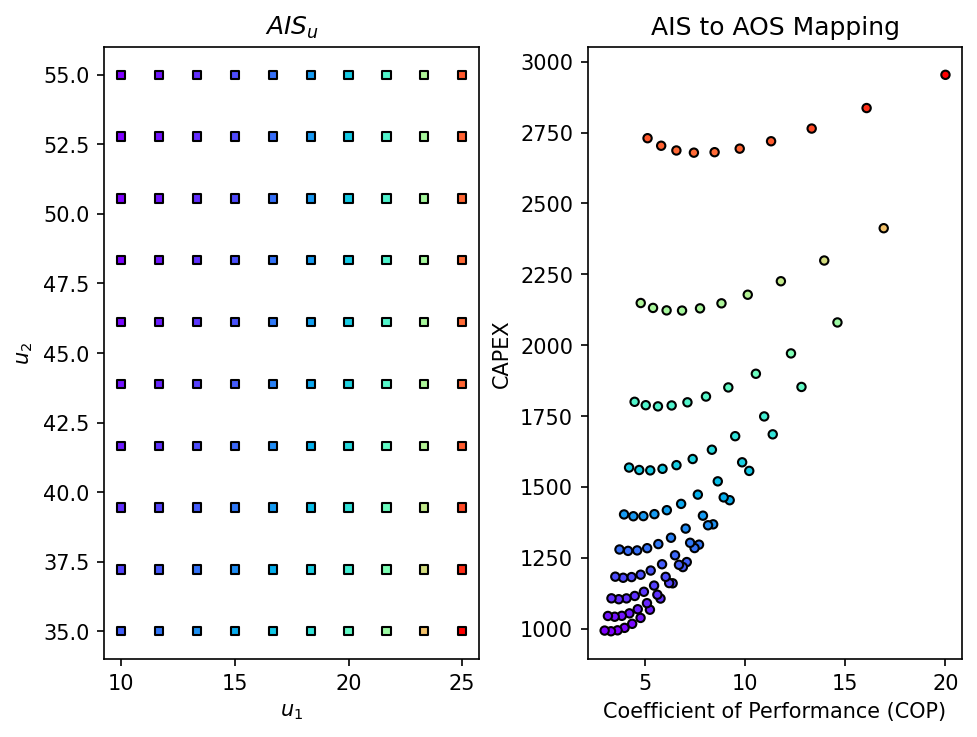

In [9]:
# Generate the AIS to AOS mapping

AIS, AOS = AIS2AOS_map(air_cooling_problem, AIS_bounds, resolution, plot=True)

plt.title("AIS to AOS Mapping")
plt.xlabel("Coefficient of Performance (COP)")
plt.ylabel("CAPEX")
plt.show()

The plots show how the evaporator and condenser temperatures affect the system's COP and CAPEX. We can also generate a visualization of the Achievable Output Set (AOS) using the `multimodel_rep` function from opyrability.

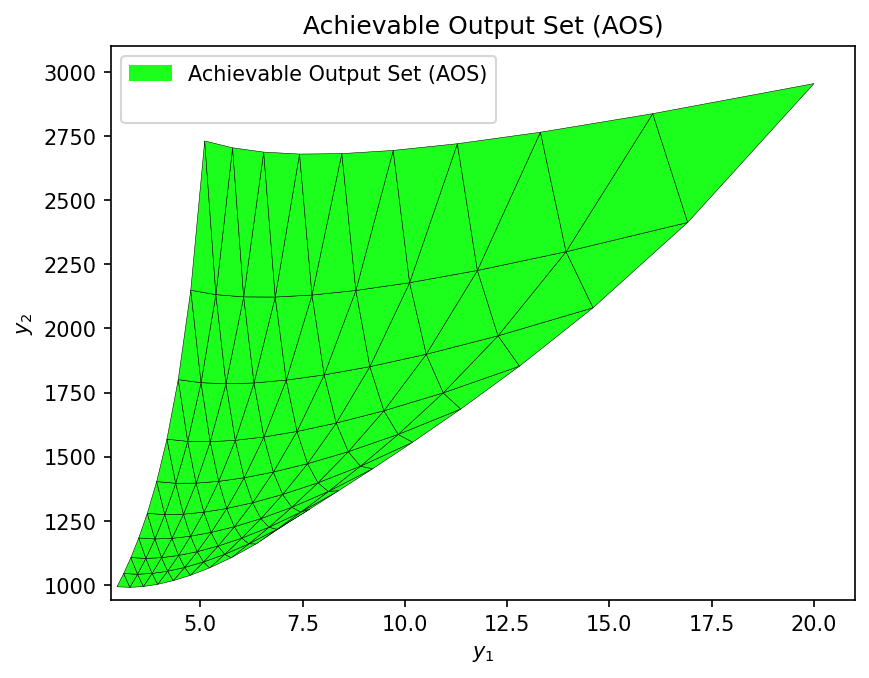

In [10]:
# Generate the AOS region representation
AOS_region = multimodel_rep(air_cooling_problem, AIS_bounds, resolution)

plt.show()

With the Achievable Output Set (AOS) mapped, we can define a Desired Output Set (DOS) and calculate the Operability Index (OI). The OI quantifies the fraction of the DOS that is achievable by the process given the AIS.

For this example, we define the DOS based on the following performance requirements:

- **COP:** 5.0 - 8.0
- **CAPEX:** 800 - 1500

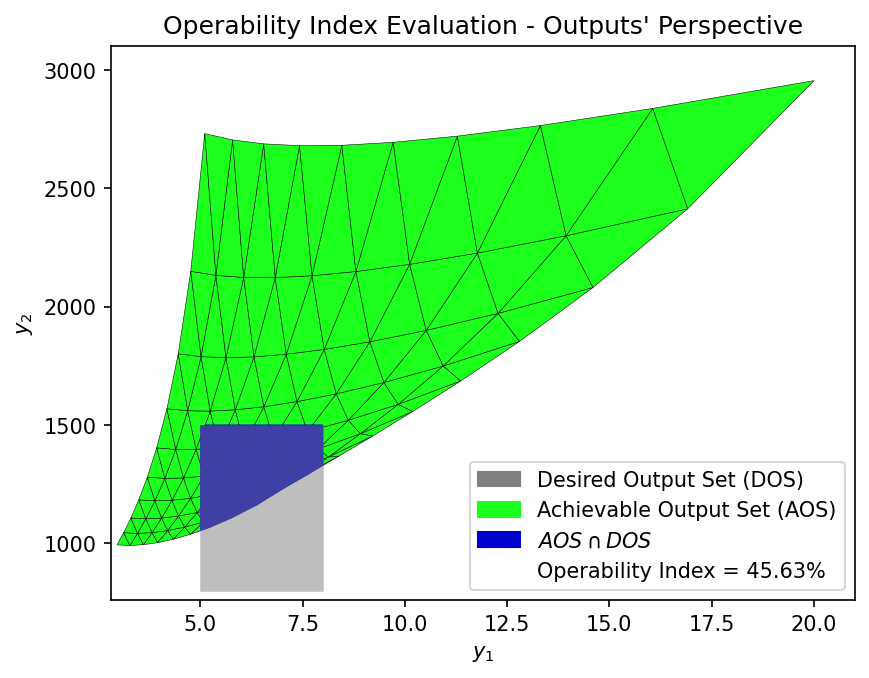

In [11]:
# Define the Desired Output Set (DOS) bounds
DOS_bounds = np.array([
    [5, 8],      # Coefficient of Performance (COP)
    [800, 1500]  # CAPEX
])

# Evaluate and plot the Operability Index
OI = OI_eval(AOS_region, DOS_bounds)

The plot above illustrates the Achievable Output Set (AOS) for the air cooling system against our defined Desired Output Set (DOS).

The calculated **Operability Index (OI)** quantifies the portion of the desired performance targets (in terms of COP and CAPEX) that are achievable within the investigated temperature ranges.